In [ ]:
import warnings
warnings.filterwarnings("ignore") # ignoring warnings

# importing the required libraries 
import random 
import pandas as pd 
import numpy as np
# plotting libraries
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb
from tqdm import tqdm

from collections import Counter 
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  RandomizedSearchCV

In [ ]:
# loading the train and test data into pandas dataframe

tr_df = pd.read_csv('/content/train.csv')
te_df = pd.read_csv('/content/test.csv')

In [ ]:
# adding extra features for test data 
te_df['is_cat3_sameas_cat90']=np.where(te_df['cat3']==te_df['cat90'],1,0)

te_df['is_cat7_sameas_cat89']=np.where(te_df['cat7']==te_df['cat89'],1,0)

te_df['is_cat2_sameas_cat9']=np.where(te_df['cat2']==te_df['cat9'],1,0)

te_df['is_cat6_sameas_cat50']=np.where(te_df['cat6']==te_df['cat50'],1,0)

In [ ]:
# As cat3 and cat90 are highly correlated adding new features which says both are same or different .
# 1 if same 0 if different ..... same for remaining features .. 

tr_df['is_cat3_sameas_cat90']=np.where(tr_df['cat3']==tr_df['cat90'],1,0)

tr_df['is_cat7_sameas_cat89']=np.where(tr_df['cat7']==tr_df['cat89'],1,0)

tr_df['is_cat2_sameas_cat9']=np.where(tr_df['cat2']==tr_df['cat9'],1,0)

tr_df['is_cat6_sameas_cat50']=np.where(tr_df['cat6']==tr_df['cat50'],1,0)

In [ ]:
# Getting categorical column names and continous column names 

cat_features = [i for i in tr_df.columns if i[:3]=='cat']

cont_features = [i for i in tr_df.columns if i[:4]=='cont']

In [ ]:
te_df['loss'] = np.nan
joined = pd.concat([tr_df, te_df])

In [ ]:
def filter_cat(x):
    if x in remove:
        return np.nan
    return x

In [ ]:
for i in cat_features:
    if tr_df[i].nunique() != te_df[i].nunique():
        set_train = set(tr_df[i].unique())
        set_test = set(te_df[i].unique())
        remove_train = set_train - set_test
        remove_test = set_test - set_train
        remove = remove_train.union(remove_test)
        
        joined[i] = joined[i].apply(lambda x: filter_cat(x), axis=1)
            
    joined[i] = pd.factorize(joined[i].values, sort=True)[0]

## Training Baseline Models

In [ ]:
shift = 200

y = np.log(tr_df['loss']+shift)

X = tr_df.drop(['loss', 'id'], axis=1)
te_df = te_df.drop(['loss', 'id'],axis= 1)

X_train , X_cv , y_train , y_cv = train_test_split(X,y,test_size=0.25, random_state = 45)

In [ ]:
def run_models(X_train,y_train,X_cv,y_cv):
    model_eln = ElasticNet()
    model_las = Lasso()
    model_rid = Ridge()
    model_lr  = LinearRegression()
    model_dt  = DecisionTreeRegressor()
    model_xgb = XGBRegressor()
    model_adb = AdaBoostRegressor()
    model_rf  = RandomForestRegressor()
    model_knn = KNeighborsRegressor()

    models = [model_xgb,model_adb,model_rf,model_knn,model_eln,model_las,model_rid,model_lr,model_dt]
    model_names = ['xgb','AdaBoost','RandomForest','KNN','ElasticNet','Lasso','Ridge','Linear','DecisionTree']
    model_dict = {}
    
    for i in range(len(models)):
        models[i].fit(X_train,y_train)
        pred =  models[i].predict(X_cv)
        a = mean_absolute_error(np.exp(y_cv)-shift, np.exp(pred)-shift)
        model_dict.update({model_names[i]:a})
        
    return model_dict

In [ ]:
model_performance = run_models(X_train,y_train,X_cv,y_cv)

## Training Baseline MLP

In [ ]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import PReLU,Dropout
from tensorflow.keras import Sequential

In [ ]:
#https://www.kaggle.com/mtinti/keras-starter-with-bagging-1111-84364/code

model = Sequential()
    
model.add(Dense(400, input_dim = X_train.shape[1], kernel_initializer = 'he_normal'))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(0.4))
        
model.add(Dense(200, kernel_initializer='he_normal'))
model.add(PReLU())
model.add(BatchNormalization())    
model.add(Dropout(0.2))
    
model.add(Dense(50, kernel_initializer = 'he_normal'))
model.add(PReLU())
model.add(BatchNormalization())    
model.add(Dropout(0.2))
    
model.add(Dense(1, kernel_initializer = 'he_normal'))
model.compile(loss = 'mae', optimizer = 'adam')

In [ ]:
model.fit(X_train,y_train,validation_data=(X_cv,y_cv),epochs=10)
predict = model.predict(X_cv)
error = mean_absolute_error(np.exp(y_cv)-shift,np.exp(predict)-shift)
model_performance['MLP Baseline']=error

Epoch 1/10
4414/4414 [==============================] - 21s 5ms/step - loss: 1.1059 - val_loss: 0.4405
Epoch 2/10
4414/4414 [==============================] - 20s 5ms/step - loss: 0.5784 - val_loss: 0.4238
Epoch 3/10
4414/4414 [==============================] - 20s 5ms/step - loss: 0.5310 - val_loss: 0.4055
Epoch 4/10
4414/4414 [==============================] - 20s 5ms/step - loss: 0.5082 - val_loss: 0.4022
Epoch 5/10
4414/4414 [==============================] - 20s 5ms/step - loss: 0.4877 - val_loss: 0.4088
Epoch 6/10
4414/4414 [==============================] - 20s 5ms/step - loss: 0.4725 - val_loss: 0.3977
Epoch 7/10
4414/4414 [==============================] - 21s 5ms/step - loss: 0.4577 - val_loss: 0.4171
Epoch 8/10
4414/4414 [==============================] - 21s 5ms/step - loss: 0.4467 - val_loss: 0.3958
Epoch 9/10
4414/4414 [==============================] - 21s 5ms/step - loss: 0.4388 - val_loss: 0.3990
Epoch 10/10
4414/4414 [==============================] - 20s 5ms/step - l

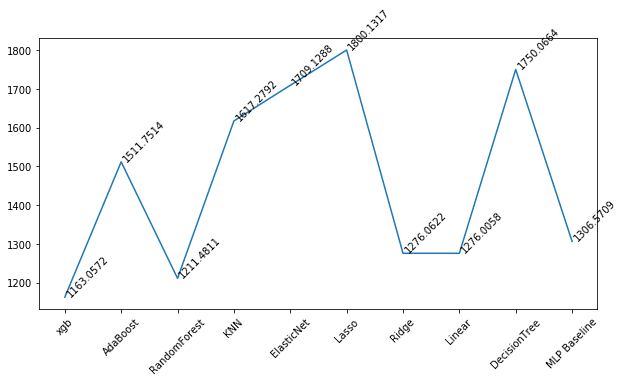

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(list(model_performance.values()))
ax.set_xticks(range(len(model_performance)))
ax.set_xticklabels(list(model_performance.keys()),rotation=45)

for i,j in enumerate(list((model_performance).values())):
    ax.annotate(str(round(j,4)),xy=(i,j+1),rotation=45)
    
plt.show()

#### Observation : 

From the above graph we can observe that linear model are not performing well . 

Tree based ensembles like boosting and bagging are performing good .

So we will hyperparameter tune the following models xbgboost , RandomForest , AdaBoost . 

Also , XGBoost performed well so we will hyperparameter tune it extensively . 

<h1 align='center'><font color='green'>Tuning tree based models </font><h1/>

In [ ]:
shift = 200

y_train = np.log(tr_df['loss']+shift)

X_tr = tr_df.drop(['loss','id'] , axis=1)

te_df = te_df.drop(['loss', 'id'],axis= 1)

## Defining MAE 

In [ ]:
# https://stackoverflow.com/questions/32401493/how-to-create-customize-your-own-scorer-function-in-scikit-learn/36560637

def eval_mae(y_pred,y_true):
    a = mean_absolute_error(np.exp(y_pred)-shift,np.exp(y_true)-shift)
    return a

my_scorer = make_scorer(eval_mae, greater_is_better=False)

##<font color='blue'>Hyperparameter tuning RandomForest</font> 

In [ ]:
model_rf = RandomForestRegressor(n_jobs=-1)

parameters = {'max_depth': [10,12] ,'n_estimators': [50,100,200]}

reg = GridSearchCV(model_rf,parameters, cv=3,scoring=my_scorer,return_train_score=True,n_jobs=-1,verbose=1)

reg.fit(X_tr, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 45.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [ ]:
reg.best_params_

{'max_depth': 12, 'n_estimators': 200}

In [ ]:
final_rf=RandomForestRegressor(max_depth=12,n_estimators=200)
final_rf.fit(X_tr, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
te_prd_rf =final_rf.predict(te_df)
prediction = np.exp(te_prd_rf) - shift

submit = pd.read_csv('sample_submission.csv')
submit['loss'] = prediction
submit.to_csv('submission_rf.csv', index=False)

#### Observations : 

Tuning the hyperparameters of random forest yielded a score of 1220.43789 on test data  and 1209.20903 on train data . 

Even after hyperparameter tuning the Random Forest it is not performing that good . 

##<font color='blue'>Hyperparameter tuning Adaboost</font> 

In [ ]:
model_adaboost = AdaBoostRegressor()

parameters = {'learning_rate':[0.1,0.5,1.0] ,'n_estimators': [50,100,200]}

reg = GridSearchCV(model_adaboost,parameters, cv=3,scoring=my_scorer,return_train_score=True,n_jobs=-1,verbose=1)

reg.fit(X_tr, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 53.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(eval_mae, greater_is_better=False), verbose=1)

In [ ]:
reg.best_params_

{'learning_rate': 0.1, 'n_estimators': 50}

In [ ]:
final_ab=AdaBoostRegressor(learning_rate= 0.1, n_estimators=50)
final_ab.fit(X_tr, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='linear',
                  n_estimators=50, random_state=None)

In [ ]:
te_prd_ab =final_ab.predict(te_df)
prediction = np.exp(te_prd_ab) - shift

submit = pd.read_csv('sample_submission.csv')
submit['loss'] = prediction
submit.to_csv('submission_ab.csv', index=False)

#### observations : 

Tuning the hyperparameters of Adaboost yielded a score of 1436.54964 on test data  and 1421.84335  on train data

Even after hyperparameter tuning the AdaBoost Regressor it is not performing that good . 

##<font color='blue'>Hyperparameter tuning XGBoost</font> 


 In an ideal world, with infinite resources and where time is not an issue, you could run a giant grid search with all the parameters together and find the optimal solution.
In fact, you might even be able to do that with really small datasets, but as the data grows bigger, training time grows too, and each step in the tuning process becomes more expensive. For this reason it is important to understand the role of the parameters and focus on the steps that we expect to impact our results the most. Here we will tune 6 of the hyperparameters that are usually having a big impact on performance. Whilst, again, it would be necessary to test all combinations to ensure we find THE optimal solution, our goal here is to find a good enough one by improving our out-of-the-box model with as few steps as possible.


Its optimal value highly depends on the other parameters, and thus it should be re-tuned each time you update a parameter. You could do this by tuning it together with all parameters in a grid-search, but it requires a lot of computational effort.

#### Tuning xgboost parameters 

In [ ]:
parameters = {
    'colsample_bytree': [0.4,0.5,0.6],
    'subsample': [0.8,0.9,0.7],
    'gamma': [0.01 , 0.1 , 1 ],
    'learning_rate': [0.1,0.01,0.15],
    'max_depth': [10,11,12], 
    'min_child_weight': [1,2,3]
}

model_xgb = XGBRegressor(n_estimators=140,objective= 'reg:linear',scoring=my_scorer,n_jobs=-1)

reg = GridSearchCV(model_xgb,parameters, cv=3,scoring=my_scorer,return_train_score=True,n_jobs=-1,verbose=1)

reg.fit(X_tr,y_train)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 41.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 178.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 412.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 1571.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 2067.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 2734.6min
[Parallel(n_jobs=-1)]: Done 2187 out of 2187 | elapsed: 3240.8min finished


[21:46:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[21:46:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { scoring } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:48:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6],
                         'gamma': [0.01, 0.1, 1],
                         'learning_rate': [0.1, 0.01, 0.15]

In [ ]:
reg.best_params_

{'colsample_bytree': 0.5,
 'gamma': 1,
 'learning_rate': 0.01,
 'max_depth': 12,
 'min_child_weight': 1,
 'subsample': 0.8}

####  Tuning n_estimator

In [ ]:
dtrain = xgb.DMatrix(X_tr, label=y_train)
dtest =  xgb.DMatrix(te_df)

In [ ]:
def log_xgboost_eval_mae(pred,dtrain):
    labels = dtrain.get_label()
    a = mean_absolute_error(np.exp(pred)-shift,np.exp(labels)-shift)
    return 'mae',a

In [ ]:
params = {
        'min_child_weight': 1,
        'eta': 0.01,
        'colsample_bytree': 0.5,
        'max_depth': 12,
        'subsample': 0.8,
        'alpha': 1,
        'gamma': 1,
        'seed': 2102
    }

In [ ]:
# https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

res = xgb.cv(params, dtrain, num_boost_round=2500, nfold=5, stratified=False,
         early_stopping_rounds=50, verbose_eval=500, feval=log_xgboost_eval_mae, maximize=False)

[0]	train-rmse:7.26350+0.00125	test-rmse:7.26350+0.00505	train-mae:3235.56392+4.96440	test-mae:3235.56401+19.85736
[500]	train-rmse:0.45669+0.00038	test-rmse:0.48472+0.00160	train-mae:1109.76436+2.04000	test-mae:1176.40286+9.11541
[1000]	train-rmse:0.42695+0.00028	test-rmse:0.47599+0.00127	train-mae:1016.24974+1.74064	test-mae:1139.76111+7.37136
[1500]	train-rmse:0.41452+0.00027	test-rmse:0.47488+0.00122	train-mae:983.46896+1.75016	test-mae:1135.91648+7.33496
[2000]	train-rmse:0.40592+0.00031	test-rmse:0.47457+0.00119	train-mae:961.50322+1.38057	test-mae:1134.76953+7.20621
[2199]	train-rmse:0.40316+0.00037	test-rmse:0.47455+0.00117	train-mae:954.52123+1.36773	test-mae:1134.61301+7.11814


#### Observation : 

From the above results we can say that as the number of trees is increasing beyond 2000 it is higly overfitting and test loss is not decreasing so we choose the n_estimators to be 2000 . 

And all other parameters are hyperparameter tuned using Grid Search . 


## <font color='blue'>Training final  XGBoost</font>


In [ ]:
#https://www.kaggle.com/mtinti/xgb-1110-from-vladimir-iglovikov-and-tilii7

params = {
        'min_child_weight': 1,
        'eta': 0.01,
        'colsample_bytree': 0.5,
        'max_depth': 12,
        'subsample': 0.8,
        'alpha': 1,
        'gamma': 1,
        'seed': 2016
    }

model = xgb.train(params, dtrain, int(2000), feval=log_xgboost_eval_mae)

prediction = np.exp(model.predict(dtest)) - shift

submit = pd.read_csv('sample_submission.csv')
submit['loss'] = prediction
submit.to_csv('submission_xgb.csv', index=False)

#### Observation : 

Tuning the hyperparameters of XGBoost yielded a score of 1128.34842  on test data  and 1114.25911 on train data. 

To improve this scores further we are going to use custom objective function which is used for training . 

## <font color='blue'>Training xgboost with custom objective function</font>

### Need for custom objective :

We know that the Mean absolute error is not differentiable so we come up with our own custom objective function which is approximation of MAE .

In [ ]:
fair_constant = 2
def fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

In [ ]:
params = {
        'min_child_weight': 1,
        'eta': 0.01,
        'colsample_bytree': 0.5,
        'max_depth': 12,
        'subsample': 0.8,
        'alpha': 1,
        'gamma': 1,
        'seed': 2016
}

model = xgb.train(params, dtrain, int(2000),obj =fair_obj,feval=log_xgboost_eval_mae)

prediction = np.exp(model.predict(dtest)) - shift

submit = pd.read_csv('sample_submission.csv')
submit['loss'] = prediction
submit.to_csv('submission_xgb_custobj.csv', index=False)

#### Observation : 

when custom objective function is used for training the XGBoost model we observed a small decrease in the MAE values .

Training the XGBoost with customobjective function  resulted in MAE of  1126.96143 on test data and  1113.22813 on train data .

So we concluded that custom objective function is adding some value .

## <font color='blue'>Lexical encoding the categorical features and adding combinations of features and using custom objective .</font>


In [ ]:
for i in cat_features:
    joined[i]=joined[i].apply(encode)

In [ ]:
#https://www.kaggle.com/misfyre/encoding-feature-comb-modkzs-1108-72665

COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

In [ ]:
for i in range(len(COMB_FEATURE)):
    for j in range(i+1,len(COMB_FEATURE)):
        feat = COMB_FEATURE[i] + '_' + COMB_FEATURE[j]
        joined[feat] = joined[COMB_FEATURE[i]] + joined[COMB_FEATURE[j]]
        joined[feat] = joined[feat].apply(encode)

In [ ]:
tr_df = joined[joined['loss'].notnull()]
te_df = joined[joined['loss'].isnull()]

In [ ]:
shift = 200

y_train = np.log(tr_df['loss']+shift)

X_tr = tr_df.drop(['loss','id'] , axis=1)

te_df = te_df.drop(['loss', 'id'],axis= 1)

In [ ]:
dtrain = xgb.DMatrix(X_tr, label=y_train)
dtest =  xgb.DMatrix(te_df)

In [ ]:
params = {
        'min_child_weight': 1,
        'eta': 0.01,
        'colsample_bytree': 0.5,
        'max_depth': 12,
        'subsample': 0.8,
        'alpha': 1,
        'gamma': 1,
        'seed': 2016
}

model = xgb.train(params, dtrain, int(2000),obj =fair_obj,feval=log_xgboost_eval_mae)

prediction = np.exp(model.predict(dtest)) - shift

submit = pd.read_csv('sample_submission.csv')
submit['loss'] = prediction
submit.to_csv('submission_featcomb_lexical_coding.csv', index=False)

#### Observation : 

In this apporach we are changing the way the categorical variables are being coded . We use modified lexical coding on categorical features and also add some combinations of categorical variables .

By following the above steps we reduced our MAE further to  1124.39302 on test data  and 1109.58634 on train data .


<h1 align='center'><font color='brown'>Summarizing the results  </font><h1/>

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", 'Private Score',"Public Score"]
x.add_row(["Random Forest",1220.43789,1209.20903])
x.add_row(["Ada Boost",1436.54964,1421.84335])
x.add_row(["Xgboost",1128.34842,1114.25911])
x.add_row(["Xgboost(with custom \n objective function)",1126.96143,1113.22813])
x.add_row(['Xgboost with feature combinations \n and custom objective func',1124.39302,1109.58634])
print(x)

+------------------------------------+---------------+--------------+
|               Model                | Private Score | Public Score |
+------------------------------------+---------------+--------------+
|           Random Forest            |   1220.43789  |  1209.20903  |
|             Ada Boost              |   1436.54964  |  1421.84335  |
|              Xgboost               |   1128.34842  |  1114.25911  |
|        Xgboost(with custom         |   1126.96143  |  1113.22813  |
|         objective function)        |               |              |
| Xgboost with feature combinations  |   1124.39302  |  1109.58634  |
|      and custom objective func     |               |              |
+------------------------------------+---------------+--------------+


<h1 align='center'><font color='brown'>Kaggle submissions </font><h1/>

<h2 align="center"><img src="https://drive.google.com/uc?export=view&id=1zSdVXga4f5phS7_6lODEKxejrUJxLXIH"></h2> 

### Procedure :

Firstly, i have used label encoding using the categorical feature values present in train data but its highly overfitting to the train data as we are giving distint value to the variable even if it occur very few times . 

From kaggle discussion forum i came to know that choose categorical values that are present in both train and test data to label encode and for remaining features assigning a value of '-1' helped to reduce the overfitting problem . 

Trained all the models to check which model is performing the best , linear models are note performing as good  as tree based models . 

Doing hyperparameter on the tree based models yielded a good results on XGBoost. 

Using custom objective function for training the model helped us to improve the performance by a small value . 

But , after going through kaggle discussion and blogs found that features interations of categorical features (combinations of features) and doing using modified lexical encoding on categorial features helped us reduce the MAE value by a good amount .  